<a href="https://colab.research.google.com/github/udaybhaskar717/Dphi/blob/main/Neuroheadstate_Eye_State_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Scientific and Data Manipulation Libraries 
import pandas as pd
import numpy as np
import math
import gc
import os
# Data Preprocessing, Machine Learning and Metrics Libraries 
from sklearn.preprocessing            import LabelEncoder, OneHotEncoder 
from sklearn.preprocessing            import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble                 import VotingClassifier
from sklearn.metrics                  import f1_score
# Boosting Algorithms 
from xgboost                          import XGBClassifier
from catboost                         import CatBoostClassifier
from lightgbm                         import LGBMClassifier
# Data Visualization Libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
data_train =pd.read_csv("/content/train_dataset.csv")
data_test =pd.read_csv("/content/test_dataset.csv")

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10486 entries, 0 to 10485
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           10486 non-null  float64
 1   F7            10486 non-null  float64
 2   F3            10486 non-null  float64
 3   FC5           10486 non-null  float64
 4   T7            10486 non-null  float64
 5   P7            10486 non-null  float64
 6   O1            10486 non-null  float64
 7   O2            10486 non-null  float64
 8   P8            10486 non-null  float64
 9   T8            10486 non-null  float64
 10  FC6           10486 non-null  float64
 11  F4            10486 non-null  float64
 12  F8            10486 non-null  float64
 13  AF4           10486 non-null  float64
 14  eyeDetection  10486 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.2 MB


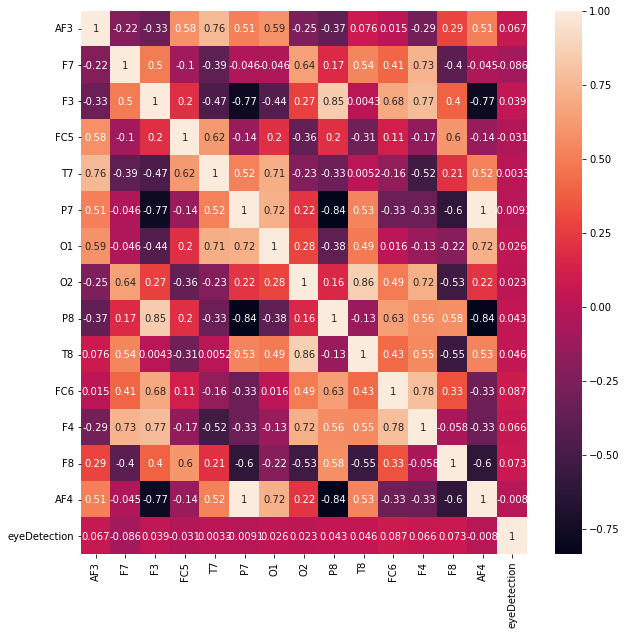

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data_train.corr(),annot=True)


# Removing correlated data

In [ ]:
def correlation (dataset, threshold):
    col_corr = set()                                     # set of all the names of correlated columns
    corr_mat = dataset.corr()
    for i in range (len(corr_mat.columns)):              #Iterating through the columns of the correlation matrix dataframe
        for j in range (i):
            if abs (corr_mat.iloc[i,j]) > threshold and (corr_mat.columns[j] not in col_corr):    # as perfect negative correlation is also a perfect correlation we are intrested in absolute values
                colname = corr_mat.columns [i]                                  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation (data_train, 0.8)
len(set(corr_features))

3

In [ ]:
corr_features

{'AF4', 'P8', 'T8'}

In [ ]:
data_train.drop(corr_features, axis=1 , inplace=True)

In [ ]:
data_test.drop(corr_features, axis=1 , inplace=True)

In [ ]:
data_train

,AF3,F7,F3,FC5,T7,P7,O1,O2,FC6,F4,F8,eyeDetection
0,4278.97,4003.59,4260.00,4113.33,4331.79,4606.67,4038.46,4584.62,4176.41,4256.92,4589.74,1
1,4294.36,4036.92,4263.59,4122.56,4341.54,4616.92,4070.77,4617.95,4208.21,4276.41,4612.31,0
2,4291.28,4000.00,4261.03,4106.15,4338.97,4622.05,4060.51,4628.72,4201.03,4283.08,4612.31,0
3,4288.72,4000.51,4255.90,4114.87,4327.18,4613.85,4069.74,4586.67,4180.00,4270.77,4596.92,0
4,4376.41,4005.64,4283.08,4141.54,4322.05,4598.46,4064.62,4606.15,4208.72,4310.77,4683.59,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10481,4285.64,3976.92,4233.33,4099.49,4341.03,4620.51,4054.87,4610.77,4177.95,4258.46,4603.59,0
10482,4285.64,3995.90,4263.59,4122.05,4332.82,4623.59,4073.33,4610.77,4209.74,4281.03,4617.95,0
10483,4260.51,3957.95,4242.05,4092.31,4317.95,4600.51,4046.15,4611.28,4193.85,4254.87,4578.46,0
10484,4295.90,4041.54,4266.67,4154.87,4350.26,4625.64,4079.49,4619.49,4197.44,4271.79,4601.54,1


In [ ]:
data_test

,AF3,F7,F3,FC5,T7,P7,O1,O2,FC6,F4,F8
0,4326.67,4047.69,4270.77,4114.87,4353.85,4631.79,4113.33,4627.18,4219.49,4292.31,4622.56
1,4282.05,3989.74,4260.00,4134.36,4350.77,4623.08,4073.85,4614.87,4189.23,4260.00,4597.44
2,4290.77,4003.08,4265.13,4098.97,4340.51,4616.92,4073.85,4612.82,4208.21,4275.38,4607.18
3,4274.36,3974.87,4244.62,4111.79,4328.72,4606.15,4053.85,4622.05,4193.33,4265.13,4588.72
4,4288.21,3976.41,4263.59,4123.08,4341.03,4624.62,4068.21,4639.49,4209.23,4293.85,4599.49
...,...,...,...,...,...,...,...,...,...,...,...
4489,4277.44,3985.64,4250.26,4118.46,4336.92,4615.38,4065.64,4614.36,4198.46,4265.13,4598.97
4490,4377.95,4013.85,4280.51,4118.46,4334.87,4618.97,4070.26,4620.51,4246.67,4308.21,4689.74
4491,4281.03,3977.44,4255.90,4123.59,4349.74,4631.28,4076.41,4626.15,4208.72,4270.26,4613.85
4492,4307.18,3992.31,4269.74,4122.05,4344.10,4633.33,4060.00,4630.26,4228.21,4289.74,4618.97


In [ ]:
def data_scaling( scaling_strategy , scaling_data , scaling_columns ):
    
    if    scaling_strategy =="RobustScaler" :
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
        
    elif  scaling_strategy =="StandardScaler" :
        scaling_data[scaling_columns] = StandardScaler().fit_transform(scaling_data[scaling_columns])
        
    elif  scaling_strategy =="MinMaxScaler" :
        scaling_data[scaling_columns] = MinMaxScaler().fit_transform(scaling_data[scaling_columns])
        
    elif  scaling_strategy =="MaxAbsScaler" :
        scaling_data[scaling_columns] = MaxAbsScaler().fit_transform(scaling_data[scaling_columns])
        
    else :  # If any other scaling send by mistake still perform Robust Scalar
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])
    
    return scaling_data

In [ ]:
scaling_strategy = ["RobustScaler", "StandardScaler","MinMaxScaler","MaxAbsScaler"]
X_train_scale = data_scaling( scaling_strategy[0] , data_train.iloc[:,:-1],data_train.iloc[:,:-1].columns )
X_test_scale  = data_scaling( scaling_strategy [0] , data_test , data_test.columns )

In [ ]:
Classifiers = {'0._XGBoost' : XGBClassifier(learning_rate =0.1, n_estimators=5000, max_depth=5,subsample = 0.70, verbosity = 0,
                                            scale_pos_weight = 2.5,updater ="grow_histmaker",base_score  = 0.5),
               
               '1.CatBoost' : CatBoostClassifier(learning_rate=0.15, n_estimators=5000, subsample=0.085, 
                                                 max_depth=5, scale_pos_weight=2.5),
               
               '2.LightGBM' : LGBMClassifier(subsample_freq = 2, objective ="binary",importance_type = "gain",
                                             verbosity = -1, max_bin = 60,num_leaves = 300,
                                             boosting_type = 'dart',learning_rate=0.15, 
                                             n_estimators=5000
                                             , max_depth=5, scale_pos_weight=2.5)
 }

print( list(Classifiers.keys()) )
print( list(Classifiers.values()) )

['0._XGBoost', '1.CatBoost', '2.LightGBM']
[XGBClassifier(max_depth=5, n_estimators=5000, scale_pos_weight=2.5,
              subsample=0.7, updater='grow_histmaker', verbosity=0), <catboost.core.CatBoostClassifier object at 0x7f6acf5d6210>, LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.15,
               max_bin=60, max_depth=5, n_estimators=5000, num_leaves=300,
               objective='binary', scale_pos_weight=2.5, subsample_freq=2,
               verbosity=-1)]


In [ ]:
ensemble_model_2 = VotingClassifier(estimators=[
                                              ('XGBoost_Best', list(Classifiers.values())[0]), 
                                              ('CatBoost_Best', list(Classifiers.values())[1]),
                                              ('LightGBM_Best', list(Classifiers.values())[2]),
                                             ], 
                                              voting='soft',weights=[5,5,5.2])

file_name = "submission"
ensemble_model_2.fit(X_train_scale,data_train.iloc[:,-1]) 

Predicted_predictions_model_2 = ensemble_model_2.predict_proba( X_test_scale )[::,1]

In [ ]:
# predictions_2 = [1 if value>=0.50009 else 0 for value in Predicted_predictions_model_2 ] # 
predictions_2 = [int(round(value)) for value in Predicted_predictions_model_2]
Result_Promoted = pd.DataFrame({'eyeDetection' : predictions_2})
pd.DataFrame(Result_Promoted).to_csv(file_name+".csv",index=False)